In [26]:
## Constants ##

TESTSUITE = '1677432096341181278'
FIELD_LABELS = (
    'sender',  # str 
    'sent',    # int [ns]
    'arrival', # int [ns]
    'valid',   # bool
    'headway', # float [s]
    'safe',    # bool 
)
FIELD_SEP = ','
ENTRY_SEP = ';'

In [13]:
## Setup Paths ## 

from pathlib import Path

PROJ_DIR = Path().absolute().parent
TESTSUITE_DIR = PROJ_DIR / 'log' / TESTSUITE

print(f'Chosen directory: {TESTSUITE_DIR.absolute()}')

Chosen directory: /home/kaarmu/Projects/wp3_tests/src/wp3_tests/log/1677432096341181278


In [49]:
## Import Test Cases ## 

import json
from dataclasses import dataclass

import pandas as pd

@dataclass
class Conf:
    AGENTS: int # [unitless]
    INIT_POS: float  # [m]
    TARG_VEL: float  # [m/s]
    TIME_STEP: float # [s]
    DATA_SIZE: float # [kB]
    DATA_FREQ: float # [Hz]
    COMP_TIME: float # [s]
    COMP_ORDR: float # [unitless]

cfs = {} # { test: configuration }
dfs = {} # { (test, vehicle): dataframe }
for path in TESTSUITE_DIR.iterdir():
    test = path.name
    for filepath in path.iterdir():
        with open(filepath) as f:
            if filepath.name == 'conf':
                cfs[test] = Conf(**json.load(f))
            else:
                vehicle = filepath.name
                dfs[test, vehicle] = pd.read_csv(f, 
                                                 names=FIELD_LABELS, 
                                                 lineterminator=ENTRY_SEP)

print(f'Collected {len(dfs)} number of testcases')

Collected 1822 number of testcases


In [62]:
print(dfs['test_0465', 'svea2']['headway'])

test_0465 = dfs['test_0465', 'svea2'][['sent', 'arrival']]
test_0534 = dfs['test_0534', 'svea2'][['sent', 'arrival']]

test_cc = pd.concat([test_0465, test_0534], axis=0)
print(test_0465['sent'])

x = test_0465['sent'] - test_0465['sent']

0     5.9
1     5.9
2     5.9
3     5.8
4     5.7
5     5.7
6     5.6
7     5.6
8     5.5
9     5.4
10    5.4
11    5.3
12    5.2
13    5.1
14    5.1
15    5.0
16    4.9
17    4.8
Name: headway, dtype: float64
0     1677435914046499490
1     1677435914070617675
2     1677435914093843698
3     1677435914118790388
4     1677435914143257856
5     1677435914169318914
6     1677435914194562196
7     1677435914219250202
8     1677435914245051145
9     1677435914269741773
10    1677435914294224500
11    1677435914318915843
12    1677435914345063447
13    1677435914371762752
14    1677435914401942253
15    1677435914429789066
16    1677435914452415466
17    1677435914483642578
Name: sent, dtype: int64


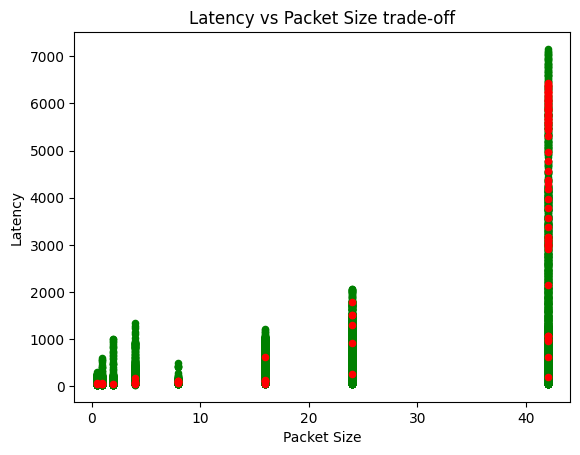

In [90]:
## Latency vs Packet Size ##

import matplotlib.pyplot as plt

# Device Under Test i.e. the vehicle(s) we want to examine
DUT = 'svea2'

fig = plt.figure()
ax = fig.gca() 

ax.set_title('Latency vs Packet Size trade-off')
ax.set_xlabel('Packet Size [kB]')
ax.set_ylabel('Latency [ms]')

res = pd.DataFrame(columns=['Packet Size', 'Latency', 'Safe']).astype({'Safe': bool})
for test, vehicle in dfs:

    if isinstance(DUT, tuple) and vehicle not in DUT: continue
    elif isinstance(DUT, str) and vehicle != DUT: continue
    
    df = dfs[test, vehicle]
    
    new = pd.DataFrame({
        'Packet Size': cfs[test].DATA_SIZE,
        'Latency': (df['arrival'] - df['sent']) / 1e6, # [ms]
        'Safe': df['safe'].astype(bool),
    })
    
    res = pd.concat([res, new])

safe = res[res['Safe']]
unsafe = res[~res['Safe']]

_ = safe.plot.scatter(x='Packet Size', y='Latency', c='green', ax=ax)
_ = unsafe.plot.scatter(x='Packet Size', y='Latency', c='red', ax=ax)

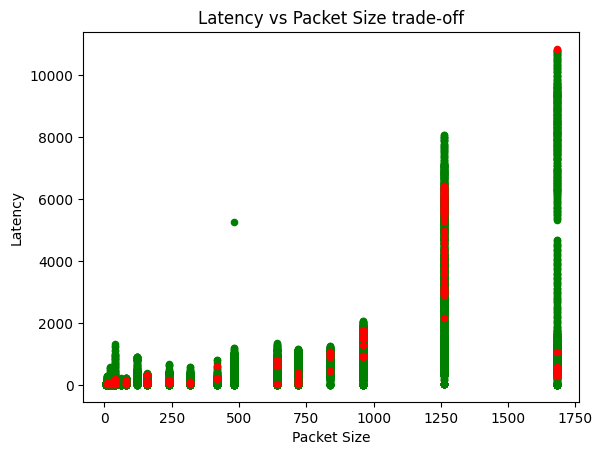

In [93]:
## Latency vs Packet Size ##

import matplotlib.pyplot as plt

# Device Under Test i.e. the vehicle(s) we want to examine
DUT = 'svea2', 'svea5'

fig = plt.figure()
ax = fig.gca() 

ax.set_title('Latency vs Packet Size trade-off')
ax.set_xlabel('Packet Size [kB]')
ax.set_ylabel('Latency [ms]')

res = pd.DataFrame(columns=['Packet Size', 'Latency', 'Safe']).astype({'Safe': bool})
for test, vehicle in dfs:

    if isinstance(DUT, tuple) and vehicle not in DUT: continue
    elif isinstance(DUT, str) and vehicle != DUT: continue
    
    df = dfs[test, vehicle]
    
    new = pd.DataFrame({
        'Packet Size': cfs[test].DATA_SIZE * cfs[test].DATA_FREQ,
        'Latency': (df['arrival'] - df['sent']) / 1e6, # [ms]
        'Safe': df['safe'].astype(bool),
    })
    
    res = pd.concat([res, new])

safe = res[res['Safe']]
unsafe = res[~res['Safe']]

_ = safe.plot.scatter(x='Packet Size', y='Latency', c='green', ax=ax)
_ = unsafe.plot.scatter(x='Packet Size', y='Latency', c='red', ax=ax)